<a href="https://colab.research.google.com/github/Itsgauravvv/Command-Speech-Recognition/blob/main/Speech_Command_Recognition_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow numpy matplotlib

Directory 'mini_speech_commands' already exists, skipping extraction.
Total number of audio files: 8000
Number of files for training: 6400
Number of files for validation/testing: 1600
Commands: ['up' 'yes' 'go' 'right' 'left' 'no' 'stop' 'down']


/tmp/ipython-input-239702910.py:41: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  commands = commands[np.in1d(commands, ignore_list, invert=True)]


Waveform shape: (16000,)
Label: down


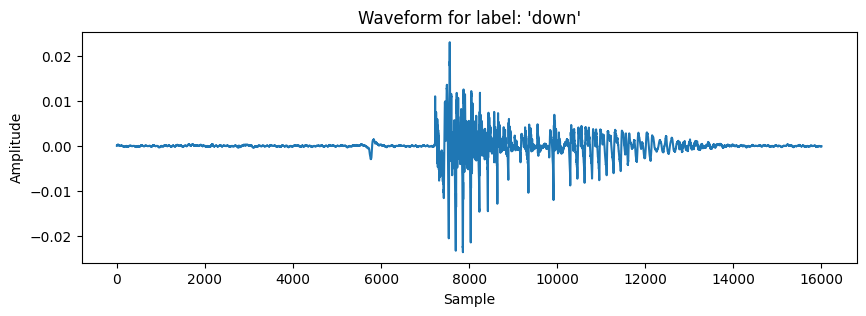

In [12]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import zipfile

tf.random.set_seed(42)
np.random.seed(42)

DATASET_PATH = 'mini_speech_commands'
data_dir = pathlib.Path(DATASET_PATH)

zip_path_str = tf.keras.utils.get_file(
    'mini_speech_commands.zip',
    origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
    extract=False,
    cache_dir='.',
    cache_subdir='.'
)

if not data_dir.exists():
    print(f"Extracting '{zip_path_str}'...")
    with zipfile.ZipFile(zip_path_str, 'r') as zf:
        zf.extractall('.')
    print("Extraction complete.")
else:
    print(f"Directory '{DATASET_PATH}' already exists, skipping extraction.")

filenames = tf.io.gfile.glob(str(data_dir) + '/*/*.wav')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print(f"Total number of audio files: {num_samples}")
print(f"Number of files for training: {int(num_samples * 0.8)}")
print(f"Number of files for validation/testing: {int(num_samples * 0.2)}")

commands = np.array(tf.io.gfile.listdir(str(data_dir)))


ignore_list = ['README.md', '__MACOSX']
commands = commands[np.in1d(commands, ignore_list, invert=True)]

print(f"Commands: {commands}")
train_files = filenames[:int(num_samples * 0.8)]
val_files = filenames[int(num_samples * 0.8):]
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

train_ds = tf.data.Dataset.from_tensor_slices(train_files)
train_ds = train_ds.map(get_waveform_and_label)

val_ds = tf.data.Dataset.from_tensor_slices(val_files)
val_ds = val_ds.map(get_waveform_and_label)

for waveform, label in train_ds.take(1):
    print(f"Waveform shape: {waveform.shape}")
    print(f"Label: {label.numpy().decode('utf-8')}")
    plt.figure(figsize=(10, 3))
    plt.plot(waveform.numpy())
    plt.title(f"Waveform for label: '{label.numpy().decode('utf-8')}'")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.show()

Spectrogram shape: (124, 129)
Label (as a number): 7


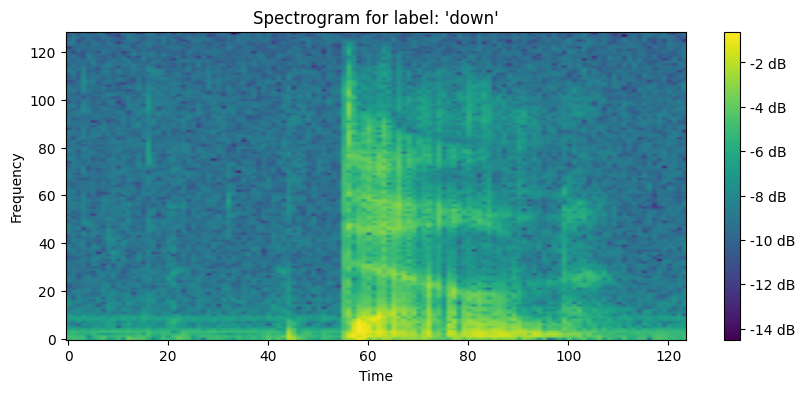

In [13]:
def preprocess_dataset(waveform, label):

    waveform = waveform[:16000]
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.concat([waveform, zero_padding], 0) # Pad

    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    label = tf.argmax(label == commands)

    return spectrogram, label
train_ds = train_ds.map(preprocess_dataset)
val_ds = val_ds.map(preprocess_dataset)

for spectrogram, label in train_ds.take(1):
    print(f"Spectrogram shape: {spectrogram.shape}")
    print(f"Label (as a number): {label.numpy()}")

    plt.figure(figsize=(10, 4))
    plt.imshow(tf.math.log(spectrogram).numpy().T, aspect='auto', origin='lower')
    plt.title(f"Spectrogram for label: '{commands[label.numpy()]}'")
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar(format='%+2.0f dB')
    plt.show()

In [14]:
def add_channel_dim(spectrogram, label):
    spectrogram = tf.expand_dims(spectrogram, -1)
    return spectrogram, label

train_ds = train_ds.map(add_channel_dim)
val_ds = val_ds.map(add_channel_dim)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.batch(32).cache().prefetch(AUTOTUNE)
val_ds = val_ds.batch(32).cache().prefetch(AUTOTUNE)

for spectrogram, _ in train_ds.take(1):
    input_shape = spectrogram.shape[1:]
print(f"Model input shape: {input_shape}")

num_labels = len(commands)

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Resizing(32, 32),
    tf.keras.layers.Normalization(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_labels, activation='softmax')
])

model.summary()

Model input shape: (124, 129, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314,891 (1.20 MB)

 Trainable params: 314,888 (1.20 MB)

 Non-trainable params: 3 (16.00 B)

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - accuracy: 0.2658 - loss: 1.9415 - val_accuracy: 0.5381 - val_loss: 1.4392
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.5016 - loss: 1.4272 - val_accuracy: 0.6731 - val_loss: 1.0948
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.6060 - loss: 1.1314 - val_accuracy: 0.7150 - val_loss: 0.9182
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.6732 - loss: 0.9190 - val_accuracy: 0.7500 - val_loss: 0.8024
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.7227 - loss: 0.7898 - val_accuracy: 0.7875 - val_loss: 0.7277
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.7453 - loss: 0.7193 - val_accuracy: 0.8006 - val_loss: 0.6549
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.7855 - loss: 0.6218 - val_accuracy: 0.7894 - val_loss: 0.7029
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.8017 - loss: 0.5665 - val_ac

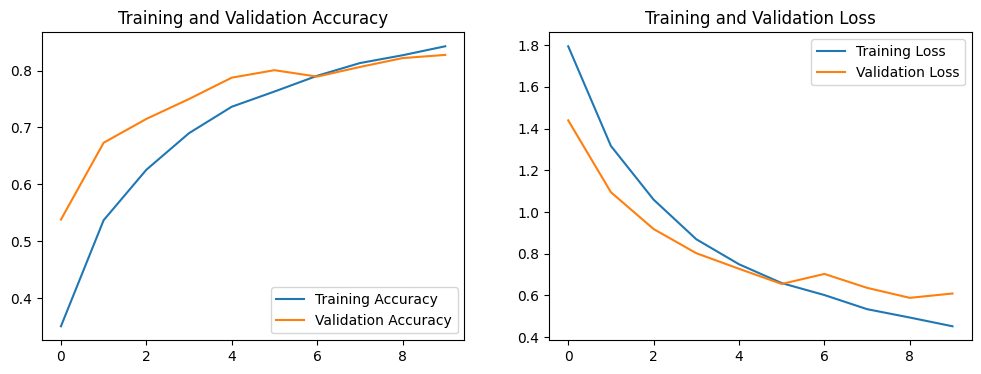

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']  # <-- Corrected
loss = history.history['loss']
val_loss = history.history['val_loss']      # <-- Corrected

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Actual label:      'no'
Predicted label:   'no'
Confidence:        90.04%


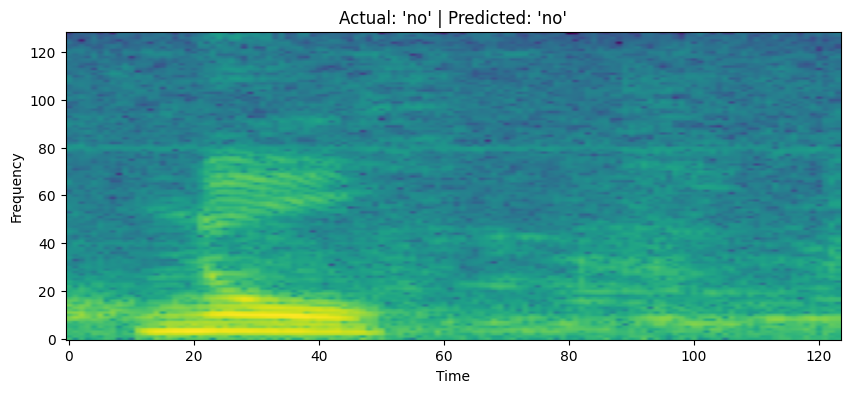

In [17]:
test_files = val_files
test_ds = tf.data.Dataset.from_tensor_slices(test_files)
test_ds = test_ds.map(get_waveform_and_label).map(preprocess_dataset)
for test_spectrogram, test_label in test_ds.take(1):
    actual_label = commands[test_label.numpy()]
    test_spectrogram_batch = tf.expand_dims(test_spectrogram, 0)
    test_spectrogram_batch = tf.expand_dims(test_spectrogram_batch, -1)

    prediction = model.predict(test_spectrogram_batch)

    predicted_label_index = np.argmax(prediction[0])
    predicted_label = commands[predicted_label_index]
    confidence = np.max(prediction[0]) * 100

    print(f"Actual label:      '{actual_label}'")
    print(f"Predicted label:   '{predicted_label}'")
    print(f"Confidence:        {confidence:.2f}%")

    plt.figure(figsize=(10, 4))
    plt.imshow(tf.math.log(test_spectrogram).numpy().T, aspect='auto', origin='lower')
    plt.title(f"Actual: '{actual_label}' | Predicted: '{predicted_label}'")
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.show()

In [11]:
!pip install pydub

In [18]:
import base64
from google.colab import output
from IPython.display import Javascript, display
import pydub
import io

JS_RECORDER = """
async function recordAudio(ms) {
  // 1. Get permission from the user
  const stream = await navigator.mediaDevices.getUserMedia({ audio: true });

  // 2. Create a recorder object
  const mediaRecorder = new MediaRecorder(stream);
  let audioChunks = [];

  // 3. Store audio data as it comes in
  mediaRecorder.ondataavailable = event => {
    audioChunks.push(event.data);
  };

  // 4. Define what happens when recording stops
  const start = new Promise(resolve => {
    mediaRecorder.onstart = () => {
      // Stop recording after the specified time
      setTimeout(() => {
        mediaRecorder.stop();
      }, ms);
    };

    mediaRecorder.onstop = () => {
      // Combine all audio chunks into a single 'blob'
      const audioBlob = new Blob(audioChunks, { type: 'audio/webm' });
      // Create a 'FileReader' to convert the blob to base64
      const reader = new FileReader();
      reader.onload = () => {
        // Resolve the promise with the base64 string
        resolve(reader.result.split(',')[1]);
      };
      reader.readAsDataURL(audioBlob);
    };
  });

  // 5. Start recording and return the promise
  mediaRecorder.start();
  return start;
}
"""

def record_audio(seconds=1):
  """
  Records audio from the user's microphone for a given duration.
  Returns: The raw audio data as bytes.
  """
  print("Recording...")
  display(Javascript(JS_RECORDER))
  b64_audio = output.eval_js(f'recordAudio({seconds * 1000})')

  print("Recording finished.")

  audio_bytes = base64.b64decode(b64_audio)
  return audio_bytes

/usr/local/lib/python3.12/dist-packages/pydub/utils.py:300: SyntaxWarning: invalid escape sequence '\('
  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:301: SyntaxWarning: invalid escape sequence '\('
  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:310: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(flt)p?( \(default\))?$', token):
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:314: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(dbl)p?( \(default\))?$', token):


Recording...


<IPython.core.display.Javascript object>

Recording finished.
DEBUG: Raw Audio RMS: 325133760.00
---
Predicted label:   'up'
Confidence:        100.00%
---


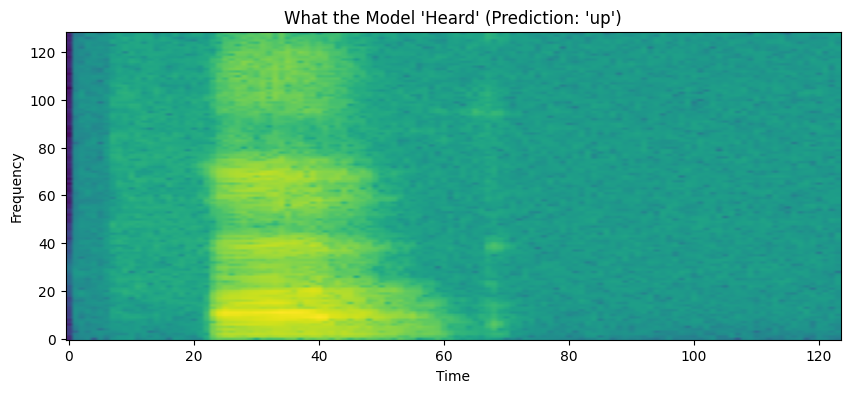

In [34]:
import tensorflow as tf
import numpy as np
import pydub
import io
def preprocess_waveform_for_prediction(waveform):
    waveform = waveform[:16000]
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, -1)
    return spectrogram

def predict_from_mic(model_to_use, command_list):
    """
    Records 1 second of audio, processes it, and predicts the command.
    """

    audio_bytes = record_audio(seconds=1)

    try:
        audio_segment = pydub.AudioSegment.from_file(io.BytesIO(audio_bytes))
    except pydub.exceptions.CouldntDecodeError:
        print("Error: Could not decode audio. Please try again.")
        return

    audio_segment = audio_segment.set_frame_rate(16000)
    audio_segment = audio_segment.set_channels(1)

    raw_samples = np.array(audio_segment.get_array_of_samples()).astype(np.float32)

    raw_rms = np.sqrt(np.mean(raw_samples**2))


    print(f"DEBUG: Raw Audio RMS: {raw_rms:.2f}")
    SILENCE_THRESHOLD = 20000000.0

    if raw_rms < SILENCE_THRESHOLD:
        print("---")
        print(f"Silence detected (RMS: {raw_rms:.2f}). No prediction made.")
        print("---")
        samples = raw_samples / (2**15)
        waveform_tensor = tf.convert_to_tensor(samples, dtype=tf.float32)
        spectrogram = preprocess_waveform_for_prediction(waveform_tensor)

        plt.figure(figsize=(10, 4))
        plt.imshow(tf.math.log(tf.squeeze(spectrogram)).numpy().T, aspect='auto', origin='lower')
        plt.title("What the Model 'Heard' (Silence)")
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.show()
        return
    samples = raw_samples / (2**15)
    waveform_tensor = tf.convert_to_tensor(samples, dtype=tf.float32)

    spectrogram = preprocess_waveform_for_prediction(waveform_tensor)
    spectrogram_batch = tf.expand_dims(spectrogram, 0)

    prediction = model_to_use.predict(spectrogram_batch, verbose=0)

    predicted_label_index = np.argmax(prediction[0])
    predicted_label = command_list[predicted_label_index]
    confidence = np.max(prediction[0]) * 100

    print("---")
    print(f"Predicted label:   '{predicted_label}'")
    print(f"Confidence:        {confidence:.2f}%")
    print("---")

    plt.figure(figsize=(10, 4))
    plt.imshow(tf.math.log(tf.squeeze(spectrogram)).numpy().T, aspect='auto', origin='lower')
    plt.title(f"What the Model 'Heard' (Prediction: '{predicted_label}')")
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.show()

predict_from_mic(model, commands)

In [35]:
model.save('my_speech_model.h5')
print("Model saved as 'my_speech_model.h5'")

Model saved as 'my_speech_model.h5'


In [36]:
%%writefile .gitignore

# 1. Ignore all model files
*.h5
*.keras

# 2. Ignore the entire dataset!
mini_speech_commands/
data/

# 3. Ignore the downloaded zip file
*.zip

# 4. Ignore other common "junk" folders
__pycache__/
.ipynb_checkpoints/
__MACOSX/

Writing .gitignore
